The input of the NN is 1D. 

In [1]:
import numpy as np
import copy
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
from torch.nn.functional import normalize
from sklearn.model_selection import train_test_split
from torch.nn.functional import normalize
import matplotlib.pyplot as plt

def quad_fn(a, b, c, x):
    return a*x**2 + b*x + c

def x_square(x: torch.tensor) -> torch.Tensor:
    return x**2

# DEFINE GIVEN FUNCTION V(x): ax^2 + bx + c
given_fn = x_square

In [11]:
# CUSTOM LOSS FUNCTION:
# def EpsilonLoss(nn.Module):

def epsilon_Loss(v_x, model_u, lower_bound, upper_bound, n_points):
    """
    GOAL: Epsilon function evaluated at u using discretized estimation
    minimizing Epsilon(u) = 
    
    ARGS: 
    n_points (int): number of discretized points on the interval [-L, L]
    e.g.: -(L)|---|---|---|---|(L) interval has n_points = 5

    v_x (torch.Tensor): function instance
    model_u (torch.Tensor): model output
    """
    sum = 0
    discrete_points = np.linspace(lower_bound, upper_bound, n_points)
    h = discrete_points[1] - discrete_points[0]
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        u_xi = model_u(x_i)

        u_prime = model_u.u_prime_2(x_i)
        
        v_xi = v_x(x_i)
        t = torch.square(u_prime) + v_xi*(u_xi**2)
        sum += t
    return 0.5*h*sum

def epsilon_Loss_penalty(v_x, model_u, lambda_pen,
                         lower_bound, upper_bound, n_points):
    """
    
    """
    sum = 0
    pen = 0

    discrete_points = np.linspace(lower_bound, upper_bound, n_points)
    h = discrete_points[1] - discrete_points[0]
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        u_xi = model_u(x_i)

        u_prime = model_u.u_prime_2(x_i)
        
        v_xi = v_x(x_i)
        t = torch.square(u_prime) + v_xi*(u_xi**2)
        sum += t
    epsilon_fn = 0.5*h*sum
    
    temp = 0
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        temp += torch.square(model_u(x_i))
    
    pen = lambda_pen * torch.square((temp*h-1))
    return epsilon_fn + pen 

# NORMALIZE MODEL u(x) OUTPUT:
def normalize_u(model_u, lower_bound, upper_bound, n_points):
    """
    Normalize model.output weight by: 
    model.output *= c
    where,
    scalar c = 1/denom
    """
    discrete_points = np.linspace(lower_bound, upper_bound, n_points)
    h = discrete_points[1] - discrete_points[0]
    s = 0
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        s += model_u(x_i)**2
    denom = math.sqrt(h) * torch.sqrt(s)
    return 1/denom

In [12]:
# CREATING MODEL CLASS
class Nonlinear(nn.Module):
    def __init__(self, n):
        # One hidden layer with n nodes
        super().__init__()
        self.hidden = nn.Linear(1, n)
        self.output = nn.Linear(n, 1)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.target_fn = given_fn

    def forward(self, x, use_tanh_fn = False, activation_on_output = False):
        if use_tanh_fn == True:
            x = self.hidden(x)
            x = self.tanh(x)
            x = self.output(x)
            
        else:
            x = self.hidden(x)
            x = self.sigmoid(x)
            x = self.output(x)
            
        if activation_on_output == False:
            return x
        else:
            if use_tanh_fn == True:
                return self.tanh(x)
            else:       
                return self.sigmoid(x)
        # output is a linear combination of the hidden layers because 
        # we perform regression ???
        return x

    def u_prime_2(self, input):
        i_tensor = torch.tensor([input.item()], requires_grad=True, dtype=torch.float)
        clone_model = copy.deepcopy(self)
        res = clone_model(i_tensor)
        res.backward()
        del clone_model
        
        return i_tensor.grad

    def u_prime(self, input):
        """
        NN with 1 hidden node layer is of the form:
        u(x) = SUM_i_to_N(a_i * sigmoid(w.x + b))

        where
        a_i is the corresponding weight of self.output layerq
        w is self.hidden.weight vector
        b is self.hidden.bias vector
        sigmoid(w.x + b) is the sigmoid-activated hidden vector

        Formula of u'(x) (for 1 hidden layer NN):
        u'(x) = SUM_i_to_N(w_i*a_i*sigmoid'(w_i*x+b))
        Note: sigmoid'(w_i*x +b) = sigmoid(w_i*x+b)*(1-sigmoid(w_i*x+b))
        """
        a_i = self.output.weight.data
        w_i = torch.transpose(self.hidden.weight.data, 0, 1)
        wi_ai = w_i * a_i

        hid_layer = self.hidden(input)
        hid_layer_T = torch.reshape(hid_layer, (list(hid_layer.shape)[0], 1))
        m = hid_layer_T * (1-hid_layer_T)

        return wi_ai @ m
    
# TRANING MODEL
    def train_network_with_penalty(self, num_epochs, v_x, optimizer, lambda_pen,
                                    lower_bound, upper_bound, n_points):
        # For plotting loss value over epochs:
        x_epochs = []
        y_loss = []
        y_loss_pen = []

        # stopping criterion:
        stop_counter = 0

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            loss_pen = epsilon_Loss_penalty(v_x, self, lambda_pen,
                                        lower_bound, upper_bound, n_points)
            loss = epsilon_Loss(v_x, self,
                                lower_bound, upper_bound, n_points)
            y_loss_pen.append(loss_pen)
            y_loss.append(loss)
            x_epochs.append(epoch)
            #check if need to stop training:
            if epoch > 0 and stop_counter >= 5:
                c = normalize_u(self, lower_bound, upper_bound, n_points)
                self.output.weight.data.copy_(c.item() * self.output.weight.data)
                self.output.bias.data.copy_(c.item() * self.output.bias.data)
                print("c value = " + str(c))
                print("LOSS VALUE WITH LAMBDA PENALTY = " 
                      + str(epsilon_Loss_penalty(v_x, self, lambda_pen,
                                                 lower_bound, upper_bound, n_points)))
                print("LOSS VALUE  = " 
                      + str(epsilon_Loss(v_x, self, lower_bound, upper_bound, n_points)))
                break
            elif epoch > 0 and stop_counter < 5:
                if torch.abs(y_loss_pen[epoch-1]-loss_pen) <= 1e-5:
                    stop_counter += 1
                else:
                    stop_counter = 0

            print('epoch {}, loss with penalty {}'.format(epoch, loss_pen.item()))
            loss_pen.backward()
            optimizer.step()

        return (x_epochs, y_loss_pen, y_loss)

    def train_network(self, num_epochs, v_x, optimizer,
                                    lower_bound, upper_bound, n_points):
        # For plotting loss value over epochs:
        x_epochs = []
        y_loss = []
        
        # stopping criterion:
        stop_counter = 0

        for epoch in range(num_epochs):

            if epoch > 0 and epoch % 50 == 0:
                c = normalize_u(self, lower_bound, upper_bound, n_points)
                print("Pre normalize: ")
                print(self.output.weight.data)
                print(self.output.bias.data)
                print("After normalize: ")
                self.output.weight.data.copy_(c.item() * self.output.weight.data)
                self.output.bias.data.copy_(c.item() * self.output.bias.data)
                print(self.output.weight.data)
                print(self.output.bias.data)
                print("c value = " + str(c))
            optimizer.zero_grad()
            loss = epsilon_Loss(v_x, self,
                                lower_bound, upper_bound, n_points)
            y_loss.append(loss)
            x_epochs.append(epoch)
            #check if need to stop training:
            if epoch > 0 and stop_counter >= 5:
                print("LOSS VALUE = " 
                      + str(epsilon_Loss(v_x, self, lower_bound, upper_bound, n_points)))
                break
            elif epoch > 0 and stop_counter < 5:
                if torch.abs(y_loss[epoch-1]-loss) <= 1e-5:
                    stop_counter += 1
                else:
                    stop_counter = 0

            print('epoch {}, loss {}'.format(epoch, loss.item()))
            loss.backward()
            optimizer.step()

        return (x_epochs, y_loss)
        

In [13]:
# DEFINE HYPER-PARAMETERS
batch_size = 50
learningRate = 0.05
num_epochs = 2000

#INIT MODEL
model = Nonlinear(20)
if torch.cuda.is_available():
    model.cuda()

# INIT OPTIMIZER CLASS
# What is an optimizer: 
# SGD:
# SGD_optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
# Adam:
adam_optimizer = torch.optim.Adam(model.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

# INIT LOSS FUNCTION: MSE
# criterion = epsilon_Loss

In [14]:
INPUT_SIZE = 1
OUTPUT_SIZE = 1

LAMBDA_PEN = 100
LOWER_BOUND = -6
UPPER_BOUND = 6
N_POINTS = 1001

# CREATING DATASET:
x_values = [i for i in np.linspace(LOWER_BOUND, UPPER_BOUND, N_POINTS)]
y_values = [given_fn(i) for i in x_values]

x_train = np.array(x_values, dtype=np.float32).reshape(-1, 1)
y_train = np.array(y_values, dtype=np.float32).reshape(-1, 1)

print(x_train.shape, y_train.shape)

(1001, 1) (1001, 1)


In [15]:
# PLOT DATA
def plot_figure(x_val, y_val, x_test=None, predicted=None):
    plt.clf()
    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(x_val, y_val, '--', label='True data', alpha=0.5)
    if predicted != None:
        plt.plot(x_test, predicted, '--', label='Predictions', alpha=0.5)
    plt.legend(loc='best')
    plt.show()

In [ ]:
graph_val = model.train_network(num_epochs, given_fn, adam_optimizer, LOWER_BOUND, UPPER_BOUND, N_POINTS)

In [ ]:
graph_val_pen = model.train_network_with_penalty(num_epochs, given_fn, adam_optimizer, LAMBDA_PEN, LOWER_BOUND, UPPER_BOUND, N_POINTS)

epoch 0, loss with penalty 9.647342681884766
epoch 1, loss with penalty 90.59369659423828
epoch 2, loss with penalty 425.99896240234375
epoch 3, loss with penalty 24.627201080322266
epoch 4, loss with penalty 93.7223129272461
epoch 5, loss with penalty 18.85395050048828
epoch 6, loss with penalty 138.9794921875
epoch 7, loss with penalty 230.26632690429688
epoch 8, loss with penalty 19.96843910217285
epoch 9, loss with penalty 26.743410110473633
epoch 10, loss with penalty 73.35962677001953
epoch 11, loss with penalty 94.17388153076172
epoch 12, loss with penalty 96.2022933959961
epoch 13, loss with penalty 85.66179656982422
epoch 14, loss with penalty 62.660404205322266
epoch 15, loss with penalty 29.269311904907227
epoch 16, loss with penalty 7.011239051818848
epoch 17, loss with penalty 35.36226272583008
epoch 18, loss with penalty 69.90795135498047
epoch 19, loss with penalty 36.845245361328125
epoch 20, loss with penalty 8.0997953414917
epoch 21, loss with penalty 13.7813777923583

In [ ]:
### Model result in using epsilon loss function
graph_val_pen[1]

In [19]:
y1

[31.92391586303711,
 13.091510772705078,
 11.899110794067383,
 45.63481140136719,
 80.02897644042969,
 32.62456512451172,
 30.58072280883789,
 66.39368438720703,
 83.5660400390625,
 57.03245544433594,
 41.6145133972168,
 56.32545471191406,
 86.68791198730469,
 95.68932342529297,
 78.63284301757812,
 67.85655975341797,
 77.12966918945312,
 94.6656723022461,
 98.17948913574219,
 85.2182846069336,
 75.08535766601562,
 79.06875610351562,
 91.55237579345703,
 98.66497802734375,
 95.22628784179688,
 90.0196304321289,
 91.00301361083984,
 96.09512329101562,
 98.2394790649414,
 95.56375885009766,
 93.01067352294922,
 94.27967834472656,
 97.27581787109375,
 98.00084686279297,
 96.5340805053711,
 96.23817443847656,
 98.18525695800781,
 99.7813949584961,
 98.93148040771484,
 97.16925811767578,
 97.13621520996094,
 98.81655883789062,
 99.92640686035156,
 99.34441375732422,
 98.45124053955078,
 98.67125701904297,
 99.45045471191406,
 99.52542114257812,
 98.99097442626953,
 98.88996887207031,
 99.41

Penalty lambda value = 100
Interval is [-6, 6], with N_POINTS = 1001


Plot 1: The epsilon_loss_with_penalty along the training epochs:


<Figure size 432x288 with 0 Axes>

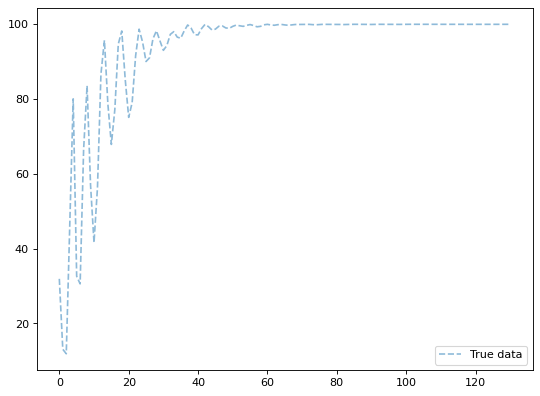



Plot 2: The epsilon_loss value along the training epochs:


<Figure size 432x288 with 0 Axes>

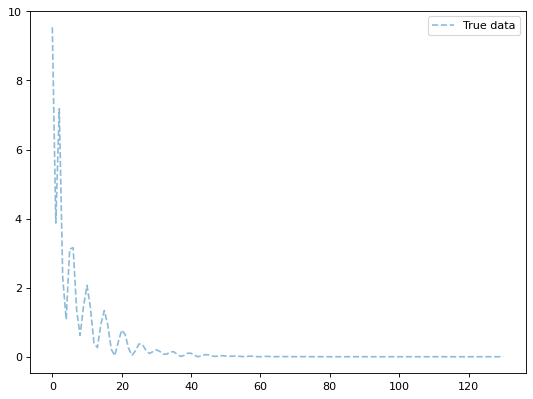



Plot 3: the model's output with input from the interval: 


<Figure size 432x288 with 0 Axes>

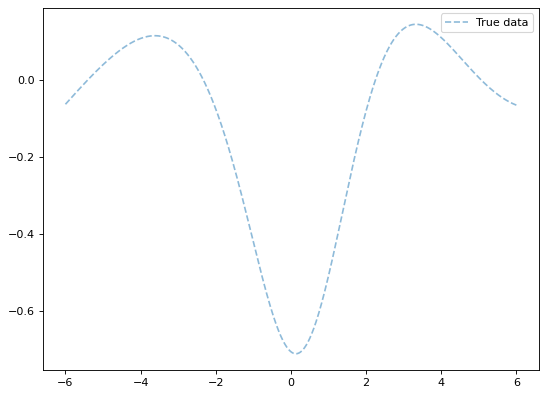

In [18]:
### Model result using epsilon loss function with penalty
print("Penalty lambda value = " + str(LAMBDA_PEN))
print("Interval is [{lb}, {ub}], with N_POINTS = {np}".format(lb=LOWER_BOUND, 
                                                              ub=UPPER_BOUND,
                                                              np=N_POINTS))
print("\n")
# Plot 1: The epsilon_loss with lambda penalty:
print("Plot 1: The epsilon_loss_with_penalty along the training epochs:")
x_epochs = graph_val_pen[0]
y1 = [i.detach().numpy().item() for i in graph_val_pen[1]]
plot_figure(x_epochs, y1)
print("\n")
# Plot 2: The epsilon_loss value when using train with penalty:
print("Plot 2: The epsilon_loss value along the training epochs:")
y2 = [i.detach().numpy().item() for i in graph_val_pen[2]]
plot_figure(x_epochs, y2)
print("\n")

# plot_figure(x_values, model_output)
# Plot 3: the model's output with input from the interval [LOWER_BOUND, UPPER_BOUND]:
print("Plot 3: the model's output with input from the interval: ")
x_vals = [torch.tensor([i], requires_grad=True, dtype=torch.float) for i in x_train]

model_output = []
for i in x_vals:
    model_output.append(model(i).detach().numpy().item())

plot_figure(x_values, model_output)

<Figure size 432x288 with 0 Axes>

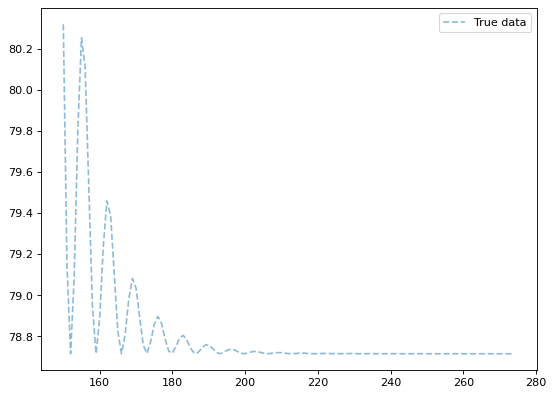

In [ ]:
plot_figure(graph_val[0][150:], loss_val[150:])

Dear professor, here's my current progress:
1. I implement epsilon_Loss_penalty function. Now, the training process will iterate until it counts 5 consecutive times the loss difference between the current loss values with its previous loss < 1e-5. 

    Then, it finds the normalization constant c and apply to model.output weight layer and its bias. Then the algorithm updates the normalized output weight layer for the model. 

    The result: the training process only takes < 300 epochs to converge to a loss value of 78.7160. This occurs consistently after several re-runs. The problem: the constant c is 1 from my normalization function. I'm looking for a normalization from the PyTorch library to use instead. Please let me know if I can use this function for the normalization part: [PyTorch normalization function](https://pytorch.org/docs/stable/generated/torch.nn.functional.normalize.html)


<Figure size 432x288 with 0 Axes>

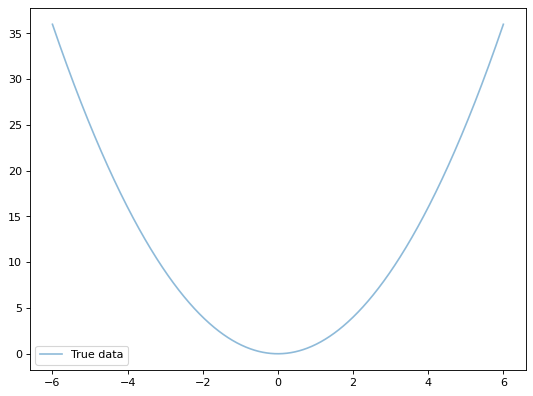

In [ ]:
plot_figure(x_train, y_train)

# HOW TO TRAIN THE NN MODEL:
1. Reset adam_optimizer: 
```adam_opt.zero_grad()```
2. Calculate loss
3. Update the optimizer: 
```adam_opt.step()```


        weight = weight - lr * gradient

-> use lr and gradient to "improve" weight layer. 

Explanation:
```adam_opt.step()```: Update the model's parameters 


In [ ]:
model_p = Nonlinear_2(4)
adam_opt = torch.optim.Adam(model_p.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

In [ ]:
x_i = torch.tensor([-2.5], requires_grad=True, dtype=torch.float)
u_xi = model_p(x_i)
print(u_xi)
u_xi.backward()
u_prime = x_i.grad

tensor([-0.5799], grad_fn=<AddBackward0>)


In [ ]:
# Access the model's parameters:
# Model's hidden layer weight and bias
print("- Hidden layers: ")
print(model_p.hidden.weight)
print("\n")

print("- Hidden layers gradients (derivative of Loss w.r.t model params): ")
print(model_p.hidden.weight.grad)
print(model_p.hidden.bias)
print("\n")

# Model's output layer weight and bias
print("Output layers: ")
print(model_p.output.weight)
print(model_p.hidden.weight.grad)
print(model_p.output.bias)

# model.zero_grad()

i, o = (x_train[0], y_train[0])
i = Variable(torch.from_numpy(i))
o = Variable(torch.from_numpy(o))


- Hidden layers: 
Parameter containing:
tensor([[-0.4363],
        [-0.2556],
        [ 0.6323],
        [-0.8666]], requires_grad=True)


- Hidden layers gradients (derivative of Loss w.r.t model params): 
None
Parameter containing:
tensor([ 0.9463, -0.8034, -0.8181,  0.5812], requires_grad=True)


Output layers: 
Parameter containing:
tensor([[-0.3294, -0.3360,  0.0453, -0.0283]], requires_grad=True)
None
Parameter containing:
tensor([0.4850], requires_grad=True)


In [ ]:
print("- Hidden layers: ")
print(model_p.hidden.weight)
print("\n")

print("- Hidden layers gradients (derivative of Loss w.r.t model params): ")
print(model_p.hidden.weight.grad)
print(model_p.hidden.bias)
print("\n")

# Model's output layer weight and bias
print("Output layers: ")
print(model_p.output.weight)
print(model_p.hidden.weight.grad)
print(model_p.output.bias)

# model.zero_grad()

i, o = (x_train[0], y_train[0])
i = Variable(torch.from_numpy(i))
o = Variable(torch.from_numpy(o))

- Hidden layers: 
Parameter containing:
tensor([[-0.4363],
        [-0.2556],
        [ 0.6323],
        [-0.8666]], requires_grad=True)


- Hidden layers gradients (derivative of Loss w.r.t model params): 
None
Parameter containing:
tensor([ 0.9463, -0.8034, -0.8181,  0.5812], requires_grad=True)


Output layers: 
Parameter containing:
tensor([[-0.3294, -0.3360,  0.0453, -0.0283]], requires_grad=True)
None
Parameter containing:
tensor([0.4850], requires_grad=True)


In [ ]:
x.grad.zero_()

tensor([0., 0., 0.])

In [ ]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

t = 3*a**3 - b**2

external_grad = torch.tensor([1., 1.])
t.backward(gradient=external_grad)

print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


https://neptune.ai/blog/pytorch-loss-functions
https://stackoverflow.com/questions/53980031/pytorch-custom-loss-function
https://stackoverflow.com/questions/65947284/loss-with-custom-backward-function-in-pytorch-exploding-loss-in-simple-mse-exa
https://www.youtube.com/watch?v=ma2KXWblllc